In [1]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.iv import IV2SLS
import os
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBRegressor
from scipy import stats
import shap
from scipy.stats import shapiro
from scipy.stats import chisquare
from sklearn.model_selection import cross_val_score

In [20]:
#Importing Dataset
data = pd.read_stata('./NEW7080.dta')

data.rename(columns={
    'v1': 'AGE', 'v2': 'AGEQ', 'v4': 'EDUC', 'v5': 'ENOCENT', 'v6': 'ESOCENT',
    'v9': 'LWKLYWGE', 'v10': 'MARRIED', 'v11': 'MIDATL', 'v12': 'MT', 'v13': 'NEWENG',
    'v16': 'CENSUS', 'v18': 'QOB', 'v19': 'RACE', 'v20': 'SMSA', 'v21': 'SOATL',
    'v24': 'WNOCENT', 'v25': 'WSOCENT', 'v27': 'YOB'
}, inplace=True)

data.drop(columns=['v8'], inplace=True)

data['COHORT'] = 20.29
data.loc[(data['YOB'] <= 39) & (data['YOB'] >= 30), 'COHORT'] = 30.39
data.loc[(data['YOB'] <= 49) & (data['YOB'] >= 40), 'COHORT'] = 40.49

data.loc[data['CENSUS'] == 80, 'AGEQ'] = data['AGEQ'] - 1900

data['AGEQSQ'] = data['AGEQ'] ** 2

for year in range(1920, 1930):
    data[f'YR{year % 100}'] = (data['YOB'] == year).astype(int)

for q in range(1, 5):
    data[f'QTR{q}'] = (data['QOB'] == q).astype(int)

for q in range(1, 4):
    for year in range(1920, 1930):
        data[f'QTR{q}{year % 100}'] = data[f'QTR{q}'] * data[f'YR{year % 100}']

data = data[data['COHORT'] < 20.30]

# data_new = data.astype('float128')
data_new = data.astype('float64')

# <u>**Replication of Regression Results from Paper:**</u>

## TSLS (2)

In [21]:
#Stage 1 OLS Regression where Education is the endogenous variable and Quarter of birth + year are the instruments
stage1_formula = 'EDUC ~ QTR120 + QTR121 + QTR122 + QTR123 + QTR124 + QTR125 + QTR126 + QTR127 + QTR128 + QTR129 + QTR220 + QTR221 + QTR222 + QTR223 + QTR224 + QTR225 + QTR226 + QTR227 + QTR228 + QTR229 + QTR320 + QTR321 + QTR322 + QTR323 + QTR324 + QTR325 + QTR326 + QTR327 + QTR328 + QTR329 + YR20 + YR21 + YR22 + YR23 + YR24 + YR25 + YR26 + YR27 + YR28'
stage1 = smf.ols(stage1_formula, data=data).fit()

#Adding a column to the original data frame of the predicted values of education for the given values of the instruments to 
#use in the second stage regression
data['pred_education'] = stage1.predict(data)

mse_stage_one = mean_squared_error(data['pred_education'], data['EDUC'])

print(f"Mean-Squared Error: {mse_stage_one}")

#Stage 2 OLS Regression where Log Weekly Wage is the outcome variable regressed upon year of birth and
#the predicted values of education from the previous regression
stage2_formula = 'LWKLYWGE ~ pred_education + YR20 + YR21 + YR22 + YR23 + YR24 + YR25 + YR26 + YR27 + YR28'
stage2 = smf.ols(stage2_formula, data=data).fit()

#Adding a column to the original data frame of the predicted values of Log Weekly Wage to use in the manual R-Squared Test
data['predicted_LWKLYWGE'] = stage2.predict(data)

mse_stage_two = mean_squared_error(data['predicted_LWKLYWGE'], data['LWKLYWGE'])


#Printing OLS Regression Results with dotted lines for Readability
print(stage1.summary())
print('--------------------------------------------------------------------------------')
print('----------------------Regression of Interest Below------------------------------')
print('--------------------------------------------------------------------------------')
print(f"Mean-Squared Error: {mse_stage_two}")
print(stage2.summary())

Mean-Squared Error: 11.267615399549294
                            OLS Regression Results                            
Dep. Variable:                   EDUC   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     14.85
Date:                Fri, 21 Jun 2024   Prob (F-statistic):           3.29e-97
Time:                        14:41:08   Log-Likelihood:            -6.5011e+05
No. Observations:              247199   AIC:                         1.300e+06
Df Residuals:                  247159   BIC:                         1.301e+06
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    

## TSLS (4)

In [22]:
#Stage 1 OLS Regression where Education is the endogenous variable and Quarter of birth + year are the instruments
stage1_formula = 'EDUC ~ QTR120 + QTR121 + QTR122 + QTR123 + QTR124 + QTR125 + QTR126 + QTR127 + QTR128 + QTR129 + QTR220 + QTR221 + QTR222 + QTR223 + QTR224 + QTR225 + QTR226 + QTR227 + QTR228 + QTR229 + QTR320 + QTR321 + QTR322 + QTR323 + QTR324 + QTR325 + QTR326 + QTR327 + QTR328 + QTR329 + YR20 + YR21 + YR22 + YR23 + YR24 + YR25 + YR26 + YR27 + YR28 + AGEQ + AGEQSQ'
stage1 = smf.ols(stage1_formula, data=data).fit()

#Adding a column to the original data frame of the predicted values of education for the given values of the instruments to 
#use in the second stage regression
data['pred_education'] = stage1.predict(data)

mse_stage_one = mean_squared_error(data['pred_education'], data['EDUC'])

print(f"Mean-Squared Error: {mse_stage_one}")

#Stage 2 OLS Regression where Log Weekly Wage is the outcome variable regressed upon year of birth and
#the predicted values of education from the previous regression
stage2_formula = 'LWKLYWGE ~ pred_education + YR20 + YR21 + YR22 + YR23 + YR24 + YR25 + YR26 + YR27 + YR28 + AGEQ + AGEQSQ'
stage2 = smf.ols(stage2_formula, data=data).fit()


#Adding a column to the original data frame of the predicted values of Log Weekly Wage to use in the manual R-Squared Test
data['predicted_LWKLYWGE2'] = stage2.predict(data)

mse_stage_two = mean_squared_error(data['predicted_LWKLYWGE'], data['LWKLYWGE'])

#Printing OLS Regression Results with dotted lines for Readability
print(stage1.summary())
print('--------------------------------------------------------------------------------')
print('----------------------Regression of Interest Below------------------------------')
print('--------------------------------------------------------------------------------')
print(f"Mean-Squared Error: {mse_stage_two}")
print(stage2.summary())

Mean-Squared Error: 11.267615399549298
                            OLS Regression Results                            
Dep. Variable:                   EDUC   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     14.85
Date:                Fri, 21 Jun 2024   Prob (F-statistic):           3.29e-97
Time:                        14:41:11   Log-Likelihood:            -6.5011e+05
No. Observations:              247199   AIC:                         1.300e+06
Df Residuals:                  247159   BIC:                         1.301e+06
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    

## TSLS (6)

In [23]:
#Stage 1 OLS Regression where Education is the endogenous variable and Quarter of birth + year are the instruments
stage1_formula = 'EDUC ~ QTR120 + QTR121 + QTR122 + QTR123 + QTR124 + QTR125 + QTR126 + QTR127 + QTR128 + QTR129 + QTR220 + QTR221 + QTR222 + QTR223 + QTR224 + QTR225 + QTR226 + QTR227 + QTR228 + QTR229 + QTR320 + QTR321 + QTR322 + QTR323 + QTR324 + QTR325 + QTR326 + QTR327 + QTR328 + QTR329 + YR20 + YR21 + YR22 + YR23 + YR24 + YR25 + YR26 + YR27 + YR28 + RACE + MARRIED + SMSA + NEWENG + MIDATL + ENOCENT + WNOCENT + SOATL + ESOCENT + WSOCENT + MT'
stage1 = smf.ols(stage1_formula, data=data).fit()

#Adding a column to the original data frame of the predicted values of education for the given values of the instruments to 
#use in the second stage regression
data['pred_education'] = stage1.predict(data)

mse_stage_one = mean_squared_error(data['pred_education'], data['EDUC'])

print(f"Mean-Squared Error: {mse_stage_one}")

#Stage 2 OLS Regression where Log Weekly Wage is the outcome variable regressed upon year of birth and
#the predicted values of education from the previous regression
stage2_formula = 'LWKLYWGE ~ pred_education + YR20 + YR21 + YR22 + YR23 + YR24 + YR25 + YR26 + YR27 + YR28 + RACE + MARRIED + SMSA + NEWENG + MIDATL + ENOCENT + WNOCENT + SOATL + ESOCENT + WSOCENT + MT'
stage2 = smf.ols(stage2_formula, data=data).fit()


#Adding a column to the original data frame of the predicted values of Log Weekly Wage to use in the manual R-Squared Test
data['predicted_LWKLYWGE2'] = stage2.predict(data)

mse_stage_two = mean_squared_error(data['predicted_LWKLYWGE'], data['LWKLYWGE'])

#Printing OLS Regression Results with dotted lines for Readability
print(stage1.summary())
print('--------------------------------------------------------------------------------')
print('----------------------Regression of Interest Below------------------------------')
print('--------------------------------------------------------------------------------')
print(f"Mean-Squared Error: {mse_stage_two}")
print(stage2.summary())

Mean-Squared Error: 10.504819975823928
                            OLS Regression Results                            
Dep. Variable:                   EDUC   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     371.3
Date:                Fri, 21 Jun 2024   Prob (F-statistic):               0.00
Time:                        14:41:14   Log-Likelihood:            -6.4145e+05
No. Observations:              247199   AIC:                         1.283e+06
Df Residuals:                  247148   BIC:                         1.284e+06
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    

## TSLS (8)

In [24]:
#Stage 1 OLS Regression where Education is the endogenous variable and Quarter of birth + year are the instruments
stage1_formula = 'EDUC ~ QTR120 + QTR121 + QTR122 + QTR123 + QTR124 + QTR125 + QTR126 + QTR127 + QTR128 + QTR129 + QTR220 + QTR221 + QTR222 + QTR223 + QTR224 + QTR225 + QTR226 + QTR227 + QTR228 + QTR229 + QTR320 + QTR321 + QTR322 + QTR323 + QTR324 + QTR325 + QTR326 + QTR327 + QTR328 + QTR329 + YR20 + YR21 + YR22 + YR23 + YR24 + YR25 + YR26 + YR27 + YR28 + RACE + MARRIED + SMSA + NEWENG + MIDATL + ENOCENT + WNOCENT + SOATL + ESOCENT + WSOCENT + MT + AGEQ + AGEQSQ'
stage1 = smf.ols(stage1_formula, data=data).fit()

#Adding a column to the original data frame of the predicted values of education for the given values of the instruments to 
#use in the second stage regression
data['pred_education'] = stage1.predict(data)

mse_stage_one = mean_squared_error(data['pred_education'], data['EDUC'])

print(f"Mean-Squared Error: {mse_stage_one}")

#Stage 2 OLS Regression where Log Weekly Wage is the outcome variable regressed upon year of birth and
#the predicted values of education from the previous regression
stage2_formula = 'LWKLYWGE ~ pred_education + YR20 + YR21 + YR22 + YR23 + YR24 + YR25 + YR26 + YR27 + YR28 + RACE + MARRIED + SMSA + NEWENG + MIDATL + ENOCENT + WNOCENT + SOATL + ESOCENT + WSOCENT + MT + AGEQ + AGEQSQ'
stage2 = smf.ols(stage2_formula, data=data).fit()


#Adding a column to the original data frame of the predicted values of Log Weekly Wage to use in the manual R-Squared Test
data['predicted_LWKLYWGE2'] = stage2.predict(data)

mse_stage_two = mean_squared_error(data['predicted_LWKLYWGE'], data['LWKLYWGE'])

#Printing OLS Regression Results with dotted lines for Readability
print(stage1.summary())
print('--------------------------------------------------------------------------------')
print('----------------------Regression of Interest Below------------------------------')
print('--------------------------------------------------------------------------------')
print(f"Mean-Squared Error: {mse_stage_two}")
print(stage2.summary())

Mean-Squared Error: 10.504819975823926
                            OLS Regression Results                            
Dep. Variable:                   EDUC   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     371.3
Date:                Fri, 21 Jun 2024   Prob (F-statistic):               0.00
Time:                        14:41:16   Log-Likelihood:            -6.4145e+05
No. Observations:              247199   AIC:                         1.283e+06
Df Residuals:                  247148   BIC:                         1.284e+06
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    

# <u>**EDA**</u>

In [25]:
def identify_and_print_outliers(data):
    for col in data.columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        if not outliers.empty:
            print(f"Outliers in column '{col}':")
            print(outliers[col])
        else:
            print(f"No outliers found in column '{col}'.")


identify_and_print_outliers(data)

def find_highly_correlated_vars(data, threshold=0.8):
    
    corr_matrix = data.corr()
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    corr_matrix = corr_matrix.mask(mask)
    
 
    high_corr_pairs = (corr_matrix.abs() > threshold).stack()
    

    high_corr_pairs = high_corr_pairs[high_corr_pairs].index.tolist()
    

    for i, j in high_corr_pairs:
        print(f'{i} and {j} are highly correlated with correlation {corr_matrix.loc[i, j]:.2f}')
        
    return high_corr_pairs


high_corr_pairs = find_highly_correlated_vars(data, threshold=0.8)

No outliers found in column 'AGE'.
No outliers found in column 'AGEQ'.
Outliers in column 'v3':
7         2
9         2
12        2
13        2
19        2
         ..
247165    2
247170    2
247177    2
247186    2
247192    2
Name: v3, Length: 45786, dtype: int8
Outliers in column 'EDUC':
54        0
387       0
463       0
716       2
779       1
         ..
247136    0
247154    0
247155    1
247162    2
247186    2
Name: EDUC, Length: 2550, dtype: int8
Outliers in column 'ENOCENT':
16943     1
16944     1
16945     1
16946     1
16947     1
         ..
192208    1
192209    1
192210    1
192211    1
192212    1
Name: ENOCENT, Length: 53644, dtype: int8
Outliers in column 'ESOCENT':
12244     1
12245     1
12246     1
12247     1
12248     1
         ..
170247    1
170248    1
170249    1
170250    1
170251    1
Name: ESOCENT, Length: 13897, dtype: int8
Outliers in column 'v7':
9         20
33        20
37        20
40        20
43        20
          ..
247185    20
247186     5
2

# <u>**Model Selection for First Stage**</u>

## Model Selection for TSLS (2)

In [26]:
#Limiting the dataframe to the columns used in the first stage of the TSLS
data_model1 = data[['EDUC', 'QTR120', 'QTR121', 'QTR122', 'QTR123', 'QTR124', 'QTR125', 'QTR126', 'QTR127', 'QTR128', 'QTR129', 'QTR220', 'QTR221', 'QTR222', 'QTR223', 'QTR224', 'QTR225', 'QTR226', 'QTR227', 'QTR228', 'QTR229', 'QTR320', 'QTR321', 'QTR322', 'QTR323', 'QTR324', 'QTR325', 'QTR326', 'QTR327', 'QTR328', 'QTR329', 'YR20', 'YR21', 'YR22', 'YR23', 'YR24', 'YR25', 'YR26', 'YR27', 'YR28']]

#Split the data into features and target variable
X = data_model1.drop(columns=['EDUC'])
y = data_model1['EDUC']

#Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
'LinearRegression': LinearRegression(),
'Lasso': Lasso(alpha=0.1),
'Ridge': Ridge(alpha=0.1),
'ElasticNet': ElasticNet(alpha=0.1),
'DecisionTree': DecisionTreeRegressor(random_state=42),
'XGBoost': XGBRegressor(random_state=42),
}

#Train the models and evaluate them on the test set
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = {'R2': r2, 'MSE': mse}
    print(f'{name} R-squared: {r2:.6f}, MSE: {mse:.6f}')

LinearRegression R-squared: 0.001925, MSE: 11.203290
Lasso R-squared: -0.000020, MSE: 11.225120
Ridge R-squared: 0.001925, MSE: 11.203290
ElasticNet R-squared: 0.000509, MSE: 11.219185
DecisionTree R-squared: 0.001925, MSE: 11.203290
XGBoost R-squared: 0.001845, MSE: 11.204192


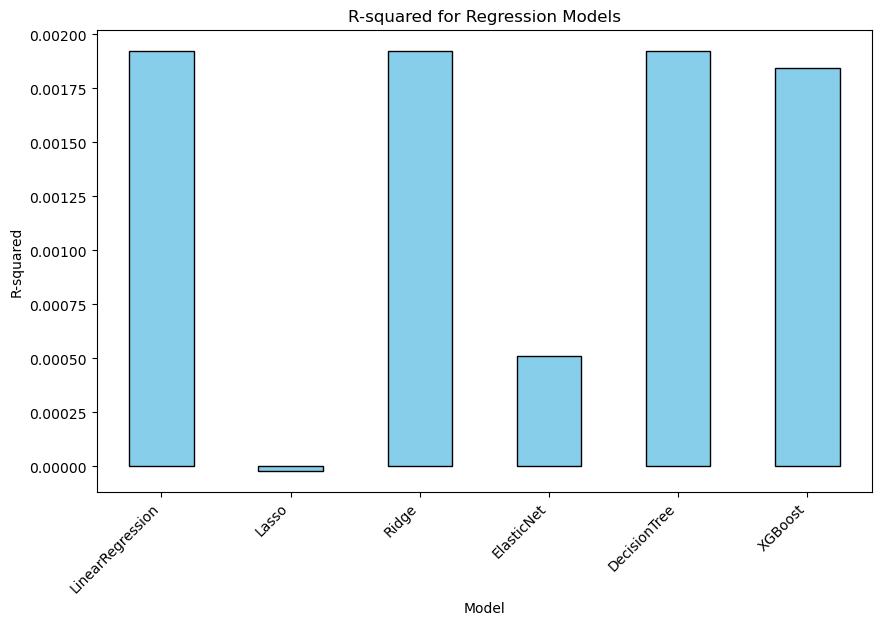

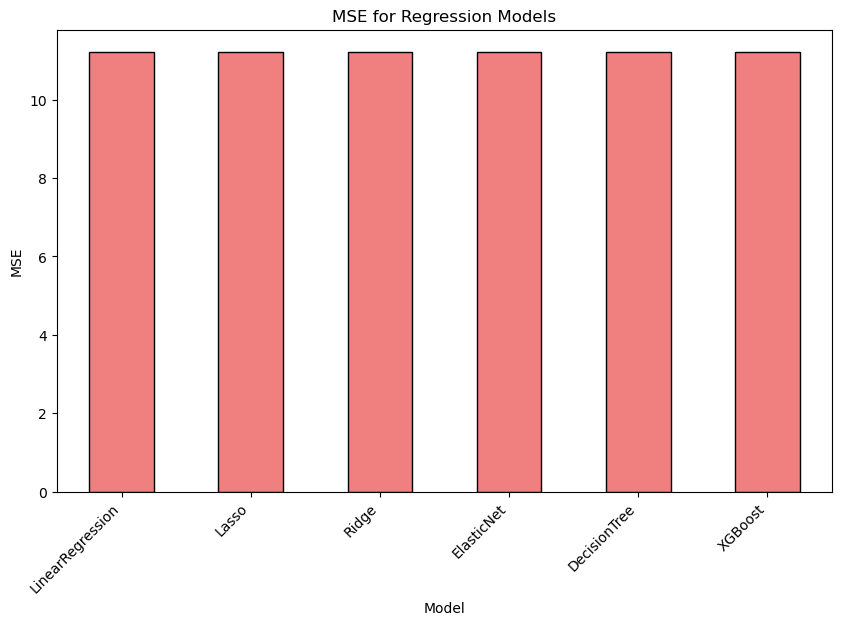

In [27]:
# Convert the results dictionary to a pandas DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['R2', 'MSE'])

# Create a bar plot of the R-squared values
ax = results_df['R2'].plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
ax.set_title('R-squared for Regression Models')
ax.set_xlabel('Model')
ax.set_ylabel('R-squared')
plt.xticks(rotation=45, ha='right')
plt.show()

# Create a bar plot of the MSE values
ax = results_df['MSE'].plot(kind='bar', figsize=(10, 6), color='lightcoral', edgecolor='black')
ax.set_title('MSE for Regression Models')
ax.set_xlabel('Model')
ax.set_ylabel('MSE')
plt.xticks(rotation=45, ha='right')
plt.show()

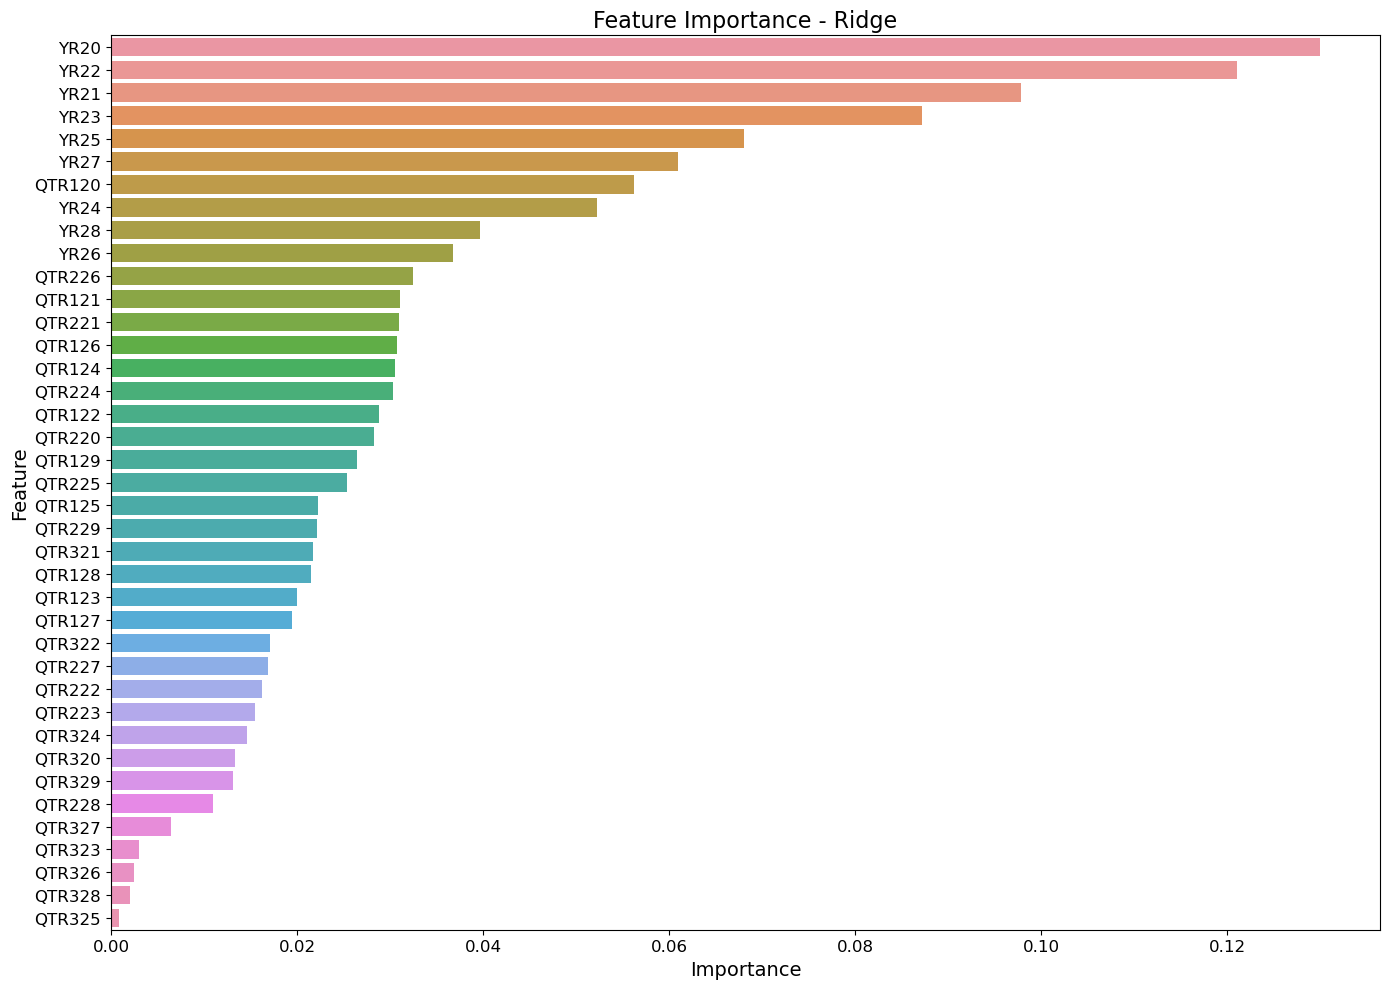

In [28]:
ridge_coefficients = models['Ridge'].coef_

# Calculate absolute values of coefficients to represent importance
ridge_feature_importance = np.abs(ridge_coefficients)

# Create a DataFrame to store the feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': ridge_feature_importance})

# Sort the DataFrame by feature importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance - Ridge', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

LinearRegression R-squared: 0.001987, MSE: 11.202591
Lasso R-squared: -0.000020, MSE: 11.225120
Ridge R-squared: 0.001987, MSE: 11.202591
ElasticNet R-squared: 0.000509, MSE: 11.219185
DecisionTree R-squared: 0.001987, MSE: 11.202591
XGBoost R-squared: 0.001987, MSE: 11.202600


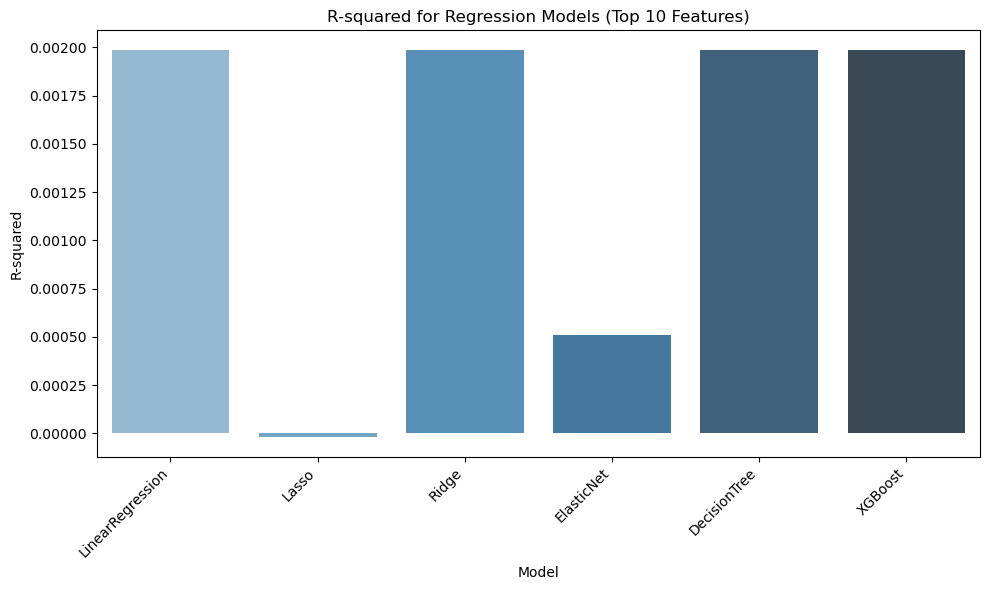

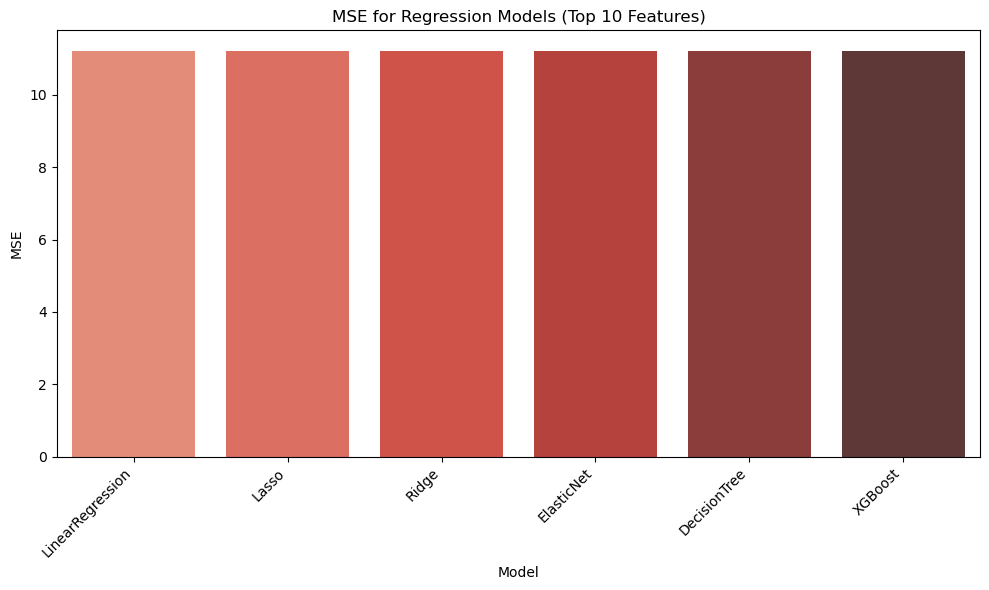

In [29]:
# Prepare the data
X = data_model1.drop(columns=['EDUC'])
y = data_model1['EDUC']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Ridge Regression model to get feature importances (coefficients)
ridge_model = Ridge(alpha=0.1)  # You can adjust alpha (regularization strength)
ridge_model.fit(X_train, y_train)

# Get coefficients (importances) from the Ridge model
coefficients = ridge_model.coef_

# Create DataFrame with feature names and coefficients
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})

# Sort the DataFrame by absolute value of coefficients in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select top 10 features for Ridge Regression
top_features = feature_importance_df.head(10)['Feature'].tolist()

# Create new feature set with top 10 features
X_top = data[top_features]
X_top_scaled = scaler.fit_transform(X_top)

# Split the data into training and testing sets with the top features
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top_scaled, y, test_size=0.2, random_state=42)

# Define the models to be evaluated
models = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(alpha=0.1),
    'Ridge': Ridge(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
}

results_top = {}
for name, model in models.items():
    model.fit(X_train_top, y_train_top)
    y_pred = model.predict(X_test_top)
    r2 = r2_score(y_test_top, y_pred)
    mse = mean_squared_error(y_test_top, y_pred)
    results_top[name] = {'R2': r2, 'MSE': mse}
    print(f'{name} R-squared: {r2:.6f}, MSE: {mse:.6f}')

# Convert the results dictionary to a pandas DataFrame
results_top_df = pd.DataFrame.from_dict(results_top, orient='index', columns=['R2', 'MSE'])

# Plotting R-squared values
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=results_top_df.index, y='R2', data=results_top_df, palette='Blues_d')
ax.set_title('R-squared for Regression Models (Top 10 Features)')
ax.set_xlabel('Model')
ax.set_ylabel('R-squared')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plotting MSE values
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=results_top_df.index, y='MSE', data=results_top_df, palette='Reds_d')
ax.set_title('MSE for Regression Models (Top 10 Features)')
ax.set_xlabel('Model')
ax.set_ylabel('MSE')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [30]:
# Define the parameter grid for Ridge Regression
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000, 10000, 100000]  # Regularization strength
}

# Initialize Ridge Regression model
ridge = Ridge(random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=3, scoring='r2')

# Fit GridSearchCV using training data
grid_search.fit(X_train_top, y_train_top)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best R-squared score: ", grid_search.best_score_)

# Use the best estimator to predict
best_ridge = grid_search.best_estimator_
y_pred_best = best_ridge.predict(X_test_top)
best_r2 = r2_score(y_test_top, y_pred_best)
best_mse = mean_squared_error(y_test_top, y_pred_best)

print(f'Best Ridge Regression R-squared: {best_r2:.6f}, MSE: {best_mse:.6f}')

Best parameters found:  {'alpha': 1000}
Best R-squared score:  0.0017081638281860971
Best Ridge Regression R-squared: 0.001969, MSE: 11.202794


## Model Selection for TSLS (4)

In [31]:
#Limiting the dataframe to the columns used in the first stage of the TSLS
data_model2 = data[['EDUC', 'QTR120', 'QTR121', 'QTR122', 'QTR123', 'QTR124', 'QTR125', 'QTR126', 'QTR127', 'QTR128', 'QTR129', 'QTR220', 'QTR221', 'QTR222', 'QTR223', 'QTR224', 'QTR225', 'QTR226', 'QTR227', 'QTR228', 'QTR229', 'QTR320', 'QTR321', 'QTR322', 'QTR323', 'QTR324', 'QTR325', 'QTR326', 'QTR327', 'QTR328', 'QTR329', 'YR20', 'YR21', 'YR22', 'YR23', 'YR24', 'YR25', 'YR26', 'YR27', 'YR28', 'AGEQ', 'AGEQSQ']]

#Split the data into features and target variable
X = data_model2.drop(columns=['EDUC'])
y = data_model2['EDUC']

#Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
'LinearRegression': LinearRegression(),
'Lasso': Lasso(alpha=0.1),
'Ridge': Ridge(alpha=0.1),
'ElasticNet': ElasticNet(alpha=0.1),
'DecisionTree': DecisionTreeRegressor(random_state=42),
'XGBoost': XGBRegressor(random_state=42),
}

#Train the models and evaluate them on the test set
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = {'R2': r2, 'MSE': mse}
    print(f'{name} R-squared: {r2:.6f}, MSE: {mse:.6f}')

LinearRegression R-squared: 0.001937, MSE: 11.203154
Lasso R-squared: 0.000905, MSE: 11.214742
Ridge R-squared: 0.001925, MSE: 11.203290
ElasticNet R-squared: 0.001610, MSE: 11.206827
DecisionTree R-squared: 0.001925, MSE: 11.203290
XGBoost R-squared: 0.001925, MSE: 11.203288


## Model Selection for TSLS (6)

In [32]:
#Limiting the dataframe to the columns used in the first stage of the TSLS
data_model3 = data[['EDUC', 'QTR120', 'QTR121', 'QTR122', 'QTR123', 'QTR124', 'QTR125', 'QTR126', 'QTR127', 'QTR128', 'QTR129', 'QTR220', 'QTR221', 'QTR222', 'QTR223', 'QTR224', 'QTR225', 'QTR226', 'QTR227', 'QTR228', 'QTR229', 'QTR320', 'QTR321', 'QTR322', 'QTR323', 'QTR324', 'QTR325', 'QTR326', 'QTR327', 'QTR328', 'QTR329', 'YR20', 'YR21', 'YR22', 'YR23', 'YR24', 'YR25', 'YR26', 'YR27', 'YR28', 'RACE', 'MARRIED', 'SMSA', 'NEWENG', 'MIDATL', 'ENOCENT', 'WNOCENT', 'SOATL', 'ESOCENT', 'WSOCENT', 'MT']]

#Split the data into features and target variable
X = data_model3.drop(columns=['EDUC'])
y = data_model3['EDUC']

#Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
'LinearRegression': LinearRegression(),
'Lasso': Lasso(alpha=0.1),
'Ridge': Ridge(alpha=0.1),
'ElasticNet': ElasticNet(alpha=0.1),
'DecisionTree': DecisionTreeRegressor(random_state=42),
'XGBoost': XGBRegressor(random_state=42),
}

#Train the models and evaluate them on the test set
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = {'R2': r2, 'MSE': mse}
    print(f'{name} R-squared: {r2:.6f}, MSE: {mse:.6f}')

LinearRegression R-squared: 0.068907, MSE: 10.451429
Lasso R-squared: 0.058355, MSE: 10.569873
Ridge R-squared: 0.068907, MSE: 10.451429
ElasticNet R-squared: 0.063411, MSE: 10.513119
DecisionTree R-squared: 0.063222, MSE: 10.515242
XGBoost R-squared: 0.070982, MSE: 10.428132


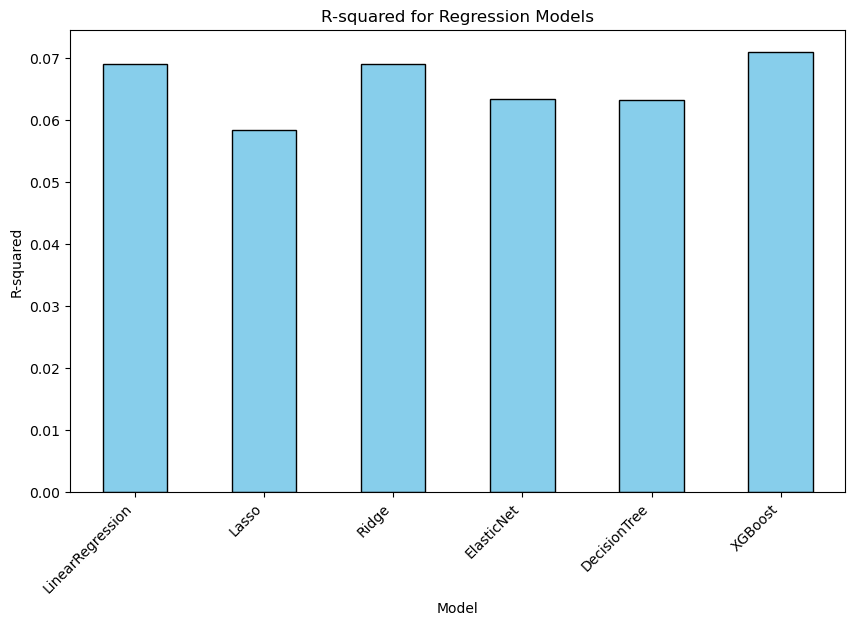

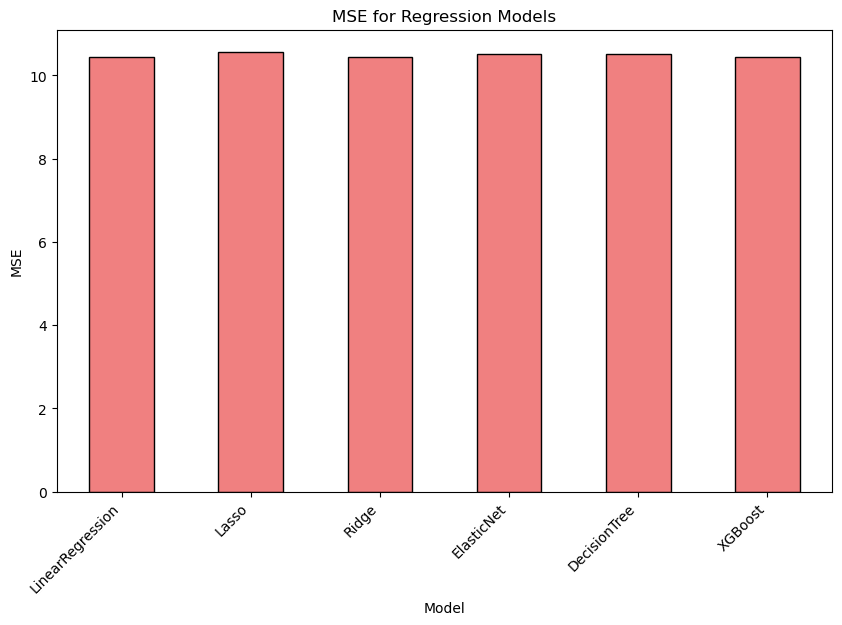

In [33]:
# Convert the results dictionary to a pandas DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['R2', 'MSE'])

# Create a bar plot of the R-squared values
ax = results_df['R2'].plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
ax.set_title('R-squared for Regression Models')
ax.set_xlabel('Model')
ax.set_ylabel('R-squared')
plt.xticks(rotation=45, ha='right')
plt.show()

# Create a bar plot of the MSE values
ax = results_df['MSE'].plot(kind='bar', figsize=(10, 6), color='lightcoral', edgecolor='black')
ax.set_title('MSE for Regression Models')
ax.set_xlabel('Model')
ax.set_ylabel('MSE')
plt.xticks(rotation=45, ha='right')
plt.show()

    Feature
39     RACE
47  ESOCENT
48  WSOCENT
46    SOATL
44  ENOCENT
30     YR20
41     SMSA
31     YR21
43   MIDATL
45  WNOCENT


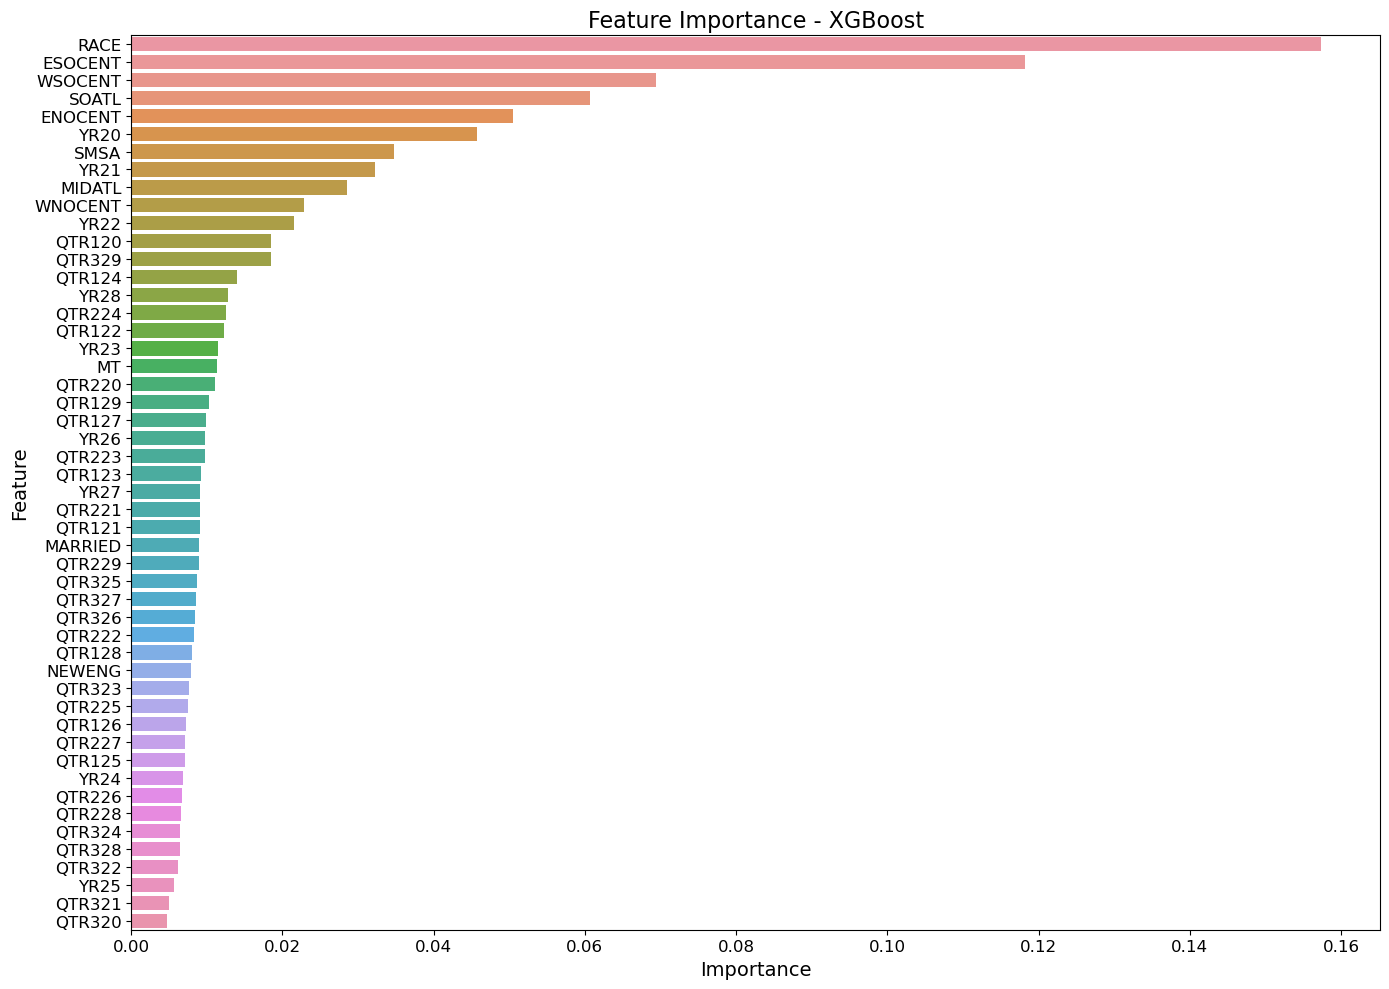

In [34]:
xgb_feature_importance1 = models['XGBoost'].feature_importances_

# Create a DataFrame to store the feature importance
feature_importance_df1 = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_feature_importance1})

# Sort the DataFrame by feature importance in descending order
feature_importance_df1 = feature_importance_df1.sort_values(by='Importance', ascending=False)

selected_features_rf1 = feature_importance_df1.head(10).drop(columns='Importance')

print(selected_features_rf1)
# Plot the feature importance
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df1)
plt.title('Feature Importance - XGBoost', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

LinearRegression R-squared: 0.067, MSE: 10.478
Lasso R-squared: 0.058, MSE: 10.574
Ridge R-squared: 0.067, MSE: 10.478
ElasticNet R-squared: 0.062, MSE: 10.524
DecisionTree R-squared: 0.072, MSE: 10.417
XGBoost R-squared: 0.072, MSE: 10.417


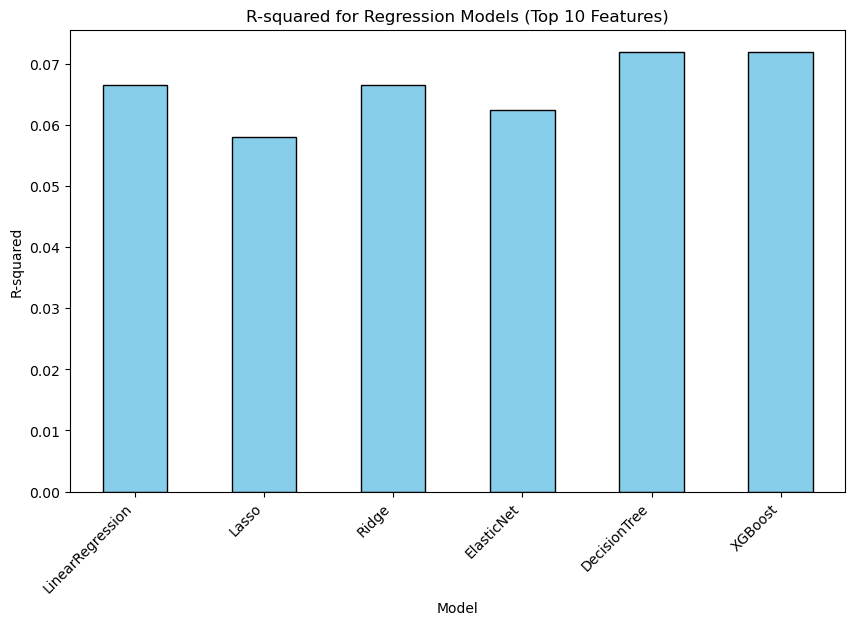

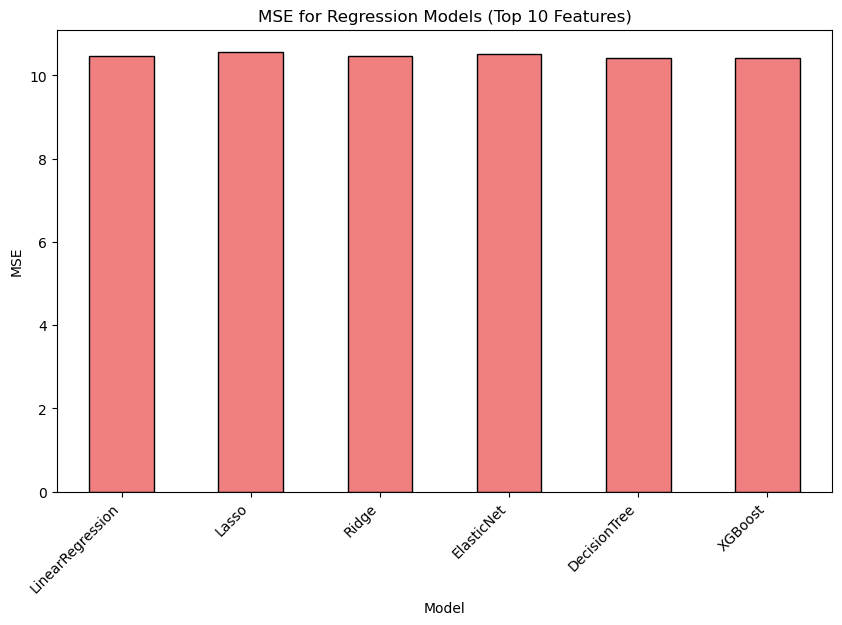

In [35]:
# Train an initial XGBoost model to get feature importances
X = data_model3.drop(columns=['EDUC'])
y = data_model3['EDUC']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
initial_model = XGBRegressor(random_state=42)
initial_model.fit(X_train, y_train)

# Get feature importances
feature_importance = initial_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


# Select top 10 features
top_features = feature_importance_df.head(10)['Feature'].tolist()

# Create new feature set with top 10 features
X_top = data_model3[top_features]

# Normalize the features
X_top_scaled = scaler.fit_transform(X_top)

# Split the data into training and testing sets
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top_scaled, y, test_size=0.2, random_state=42)


# Define the models
models = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(alpha=0.1),
    'Ridge': Ridge(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
}

results_top = {}
for name, model in models.items():
    model.fit(X_train_top, y_train_top)
    y_pred = model.predict(X_test_top)
    r2 = r2_score(y_test_top, y_pred)
    mse = mean_squared_error(y_test_top, y_pred)
    results_top[name] = {'R2': r2, 'MSE': mse}
    print(f'{name} R-squared: {r2:.3f}, MSE: {mse:.3f}')


# Convert the results dictionary to a pandas DataFrame
results_top_df = pd.DataFrame.from_dict(results_top, orient='index', columns=['R2', 'MSE'])

# Create a bar plot of the R-squared values
ax = results_top_df['R2'].plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
ax.set_title('R-squared for Regression Models (Top 10 Features)')
ax.set_xlabel('Model')
ax.set_ylabel('R-squared')
plt.xticks(rotation=45, ha='right')
plt.show()

# Create a bar plot of the MSE values
ax = results_top_df['MSE'].plot(kind='bar', figsize=(10, 6), color='lightcoral', edgecolor='black')
ax.set_title('MSE for Regression Models (Top 10 Features)')
ax.set_xlabel('Model')
ax.set_ylabel('MSE')
plt.xticks(rotation=45, ha='right')
plt.show()

In [36]:
# Example: Hyperparameter tuning for XGBoost stopped at 300 because it is optimal and higher numbers of estimators increases runtime
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3]
}

xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='r2')
grid_search.fit(X_train_top, y_train_top)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best R-squared score: ", grid_search.best_score_)

# Use the best estimator to predict
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test_top)
best_r2 = r2_score(y_test_top, y_pred_best)
best_mse = mean_squared_error(y_test_top, y_pred_best)

print(f'Best XGBoost R-squared: {best_r2:.6f}, MSE: {best_mse:.6f}')

Best parameters found:  {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100}
Best R-squared score:  0.07209983227327021
Best XGBoost R-squared: 0.072096, MSE: 10.415626


In [37]:
# Perform cross-validation on the tuned XGBoost model
cv_scores = cross_val_score(best_xgb, X_top_scaled, y, cv=5, scoring='r2')

print("Cross-validated R-squared scores:", cv_scores)
print("Mean R-squared score from cross-validation:", cv_scores.mean())

Cross-validated R-squared scores: [0.0907083  0.05831367 0.04801127 0.05792779 0.08447589]
Mean R-squared score from cross-validation: 0.06788738345626184


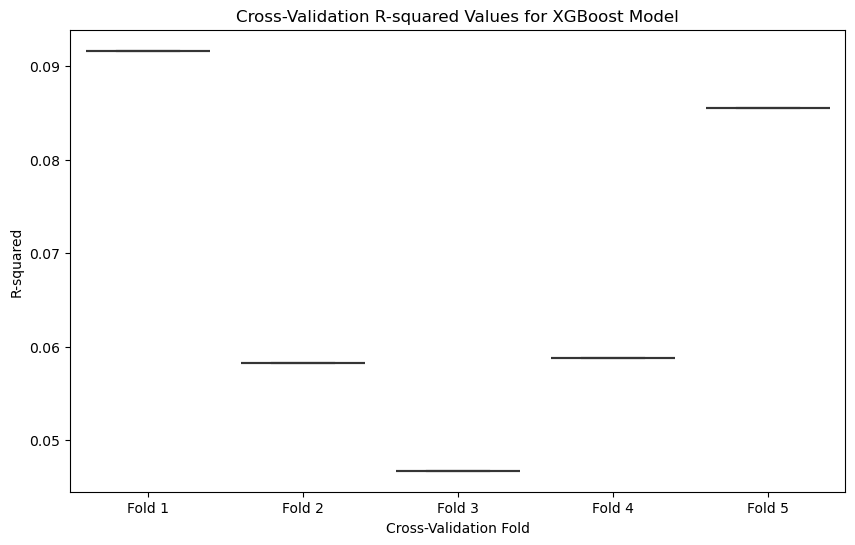

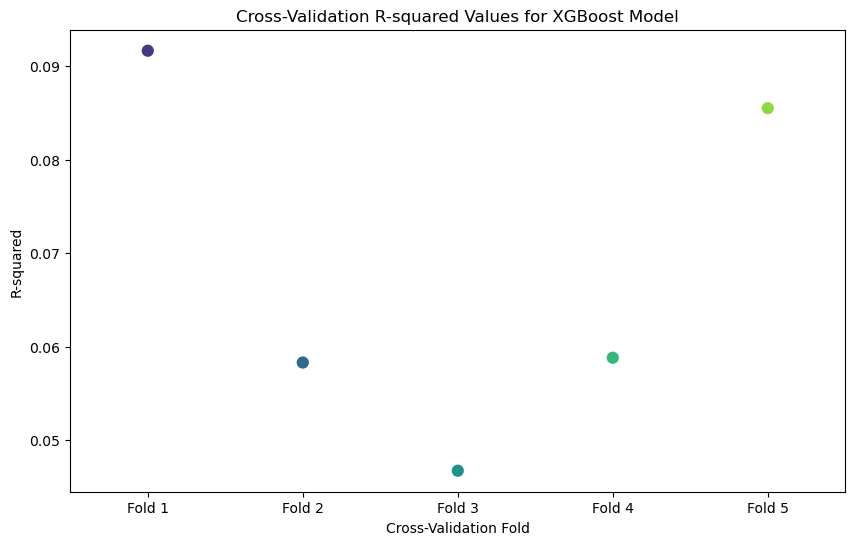

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


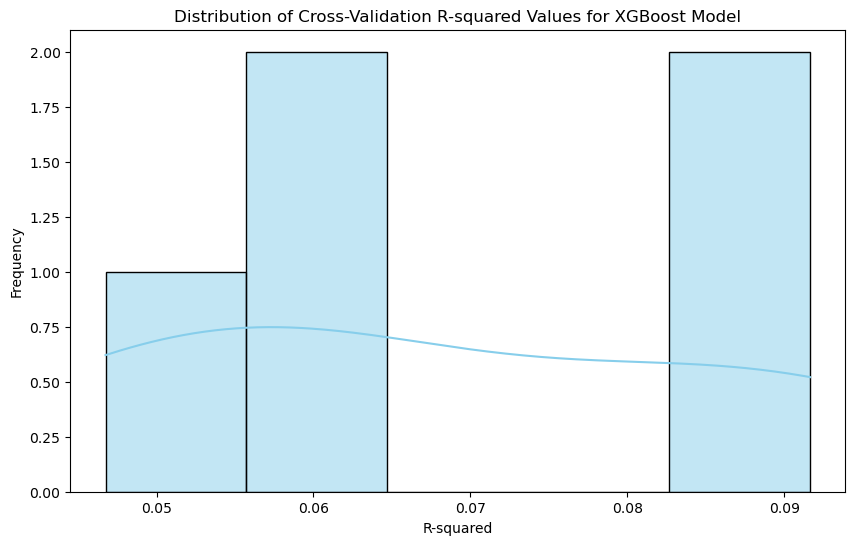

In [38]:
# Cross-validation R-squared scores
cv_scores = [0.09164598, 0.05831511, 0.04674944, 0.05882663, 0.08550493]

# Create a DataFrame for plotting
cv_results_df = pd.DataFrame({
    'Fold': ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'],
    'R-squared': cv_scores
})

# Plotting the cross-validation results
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fold', y='R-squared', data=cv_results_df, palette='viridis')
plt.title('Cross-Validation R-squared Values for XGBoost Model')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('R-squared')
plt.show()

# Plotting the cross-validation results with a point plot
plt.figure(figsize=(10, 6))
sns.pointplot(x='Fold', y='R-squared', data=cv_results_df, palette='viridis', markers='o', linestyles='-')
plt.title('Cross-Validation R-squared Values for XGBoost Model')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('R-squared')
plt.show()

# Plotting the distribution of cross-validation scores
plt.figure(figsize=(10, 6))
sns.histplot(cv_scores, kde=True, bins=5, color='skyblue')
plt.title('Distribution of Cross-Validation R-squared Values for XGBoost Model')
plt.xlabel('R-squared')
plt.ylabel('Frequency')
plt.show()


## Model Selection for TSLS (8)

In [48]:
#Limiting the dataframe to the columns used in the first stage of the TSLS
data_model4 = data[['EDUC', 'QTR120', 'QTR121', 'QTR122', 'QTR123', 'QTR124', 'QTR125', 'QTR126', 'QTR127', 'QTR128', 'QTR129', 'QTR220', 'QTR221', 'QTR222', 'QTR223', 'QTR224', 'QTR225', 'QTR226', 'QTR227', 'QTR228', 'QTR229', 'QTR320', 'QTR321', 'QTR322', 'QTR323', 'QTR324', 'QTR325', 'QTR326', 'QTR327', 'QTR328', 'QTR329', 'YR20', 'YR21', 'YR22', 'YR23', 'YR24', 'YR25', 'YR26', 'YR27', 'YR28', 'RACE', 'MARRIED', 'SMSA', 'NEWENG', 'MIDATL', 'ENOCENT', 'WNOCENT', 'SOATL', 'ESOCENT', 'WSOCENT', 'MT', 'AGEQ', 'AGEQSQ']]

#Split the data into features and target variable
X = data_model4.drop(columns=['EDUC'])
y = data_model4['EDUC']

#Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
'LinearRegression': LinearRegression(),
'Lasso': Lasso(alpha=0.1),
'Ridge': Ridge(alpha=0.1),
'ElasticNet': ElasticNet(alpha=0.1),
'DecisionTree': DecisionTreeRegressor(random_state=42),
'XGBoost': XGBRegressor(random_state=42),
}

#Train the models and evaluate them on the test set
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = {'R2': r2, 'MSE': mse}
    print(f'{name} R-squared: {r2:.6f}, MSE: {mse:.6f}')

LinearRegression R-squared: 0.068925, MSE: 10.451221
Lasso R-squared: 0.059498, MSE: 10.557039
Ridge R-squared: 0.068907, MSE: 10.451429
ElasticNet R-squared: 0.064678, MSE: 10.498889
DecisionTree R-squared: 0.063042, MSE: 10.517253
XGBoost R-squared: 0.071130, MSE: 10.426473


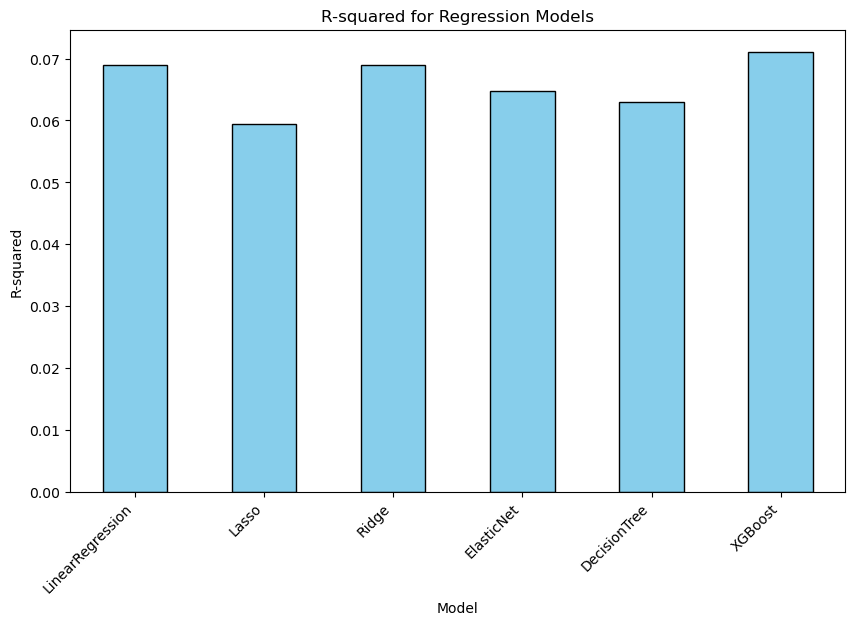

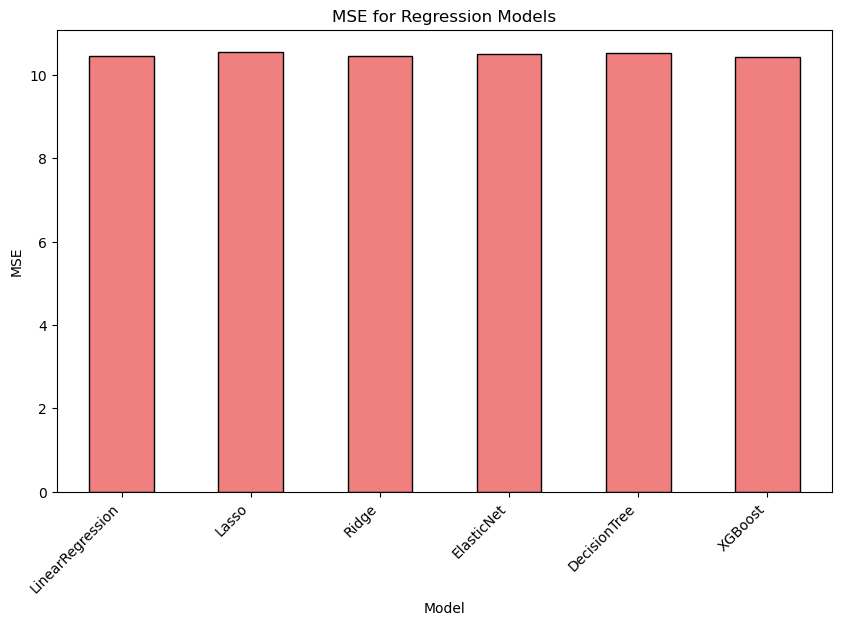

In [40]:
# Convert the results dictionary to a pandas DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['R2', 'MSE'])

# Create a bar plot of the R-squared values
ax = results_df['R2'].plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
ax.set_title('R-squared for Regression Models')
ax.set_xlabel('Model')
ax.set_ylabel('R-squared')
plt.xticks(rotation=45, ha='right')
plt.show()

# Create a bar plot of the MSE values
ax = results_df['MSE'].plot(kind='bar', figsize=(10, 6), color='lightcoral', edgecolor='black')
ax.set_title('MSE for Regression Models')
ax.set_xlabel('Model')
ax.set_ylabel('MSE')
plt.xticks(rotation=45, ha='right')
plt.show()

    Feature
39     RACE
47  ESOCENT
46    SOATL
48  WSOCENT
44  ENOCENT
43   MIDATL
41     SMSA
45  WNOCENT
50     AGEQ
49       MT


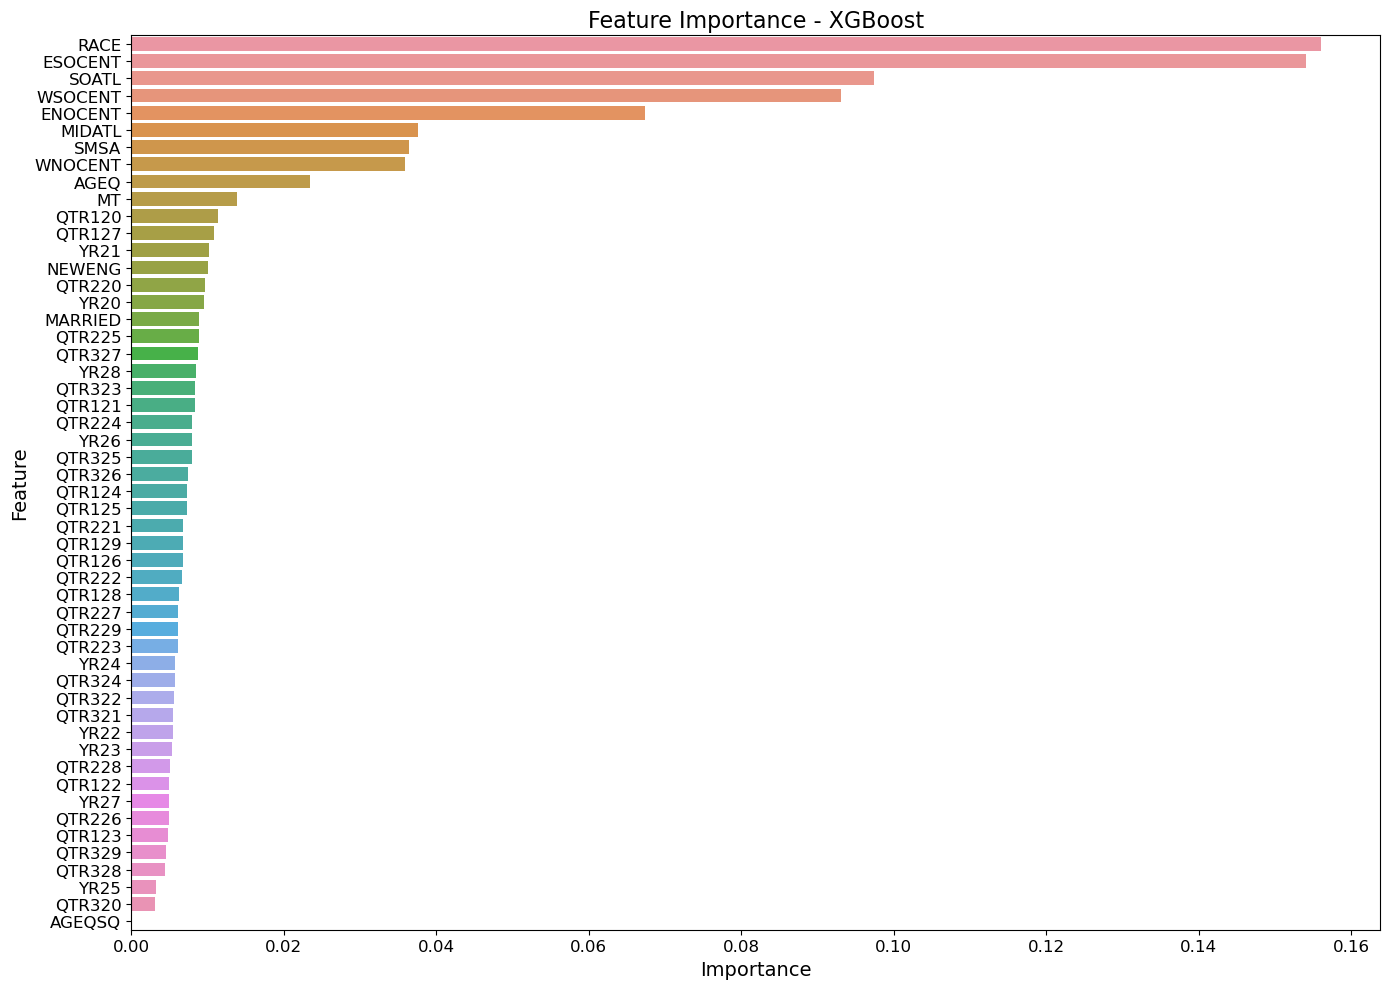

In [50]:
xgb_feature_importance2 = models['XGBoost'].feature_importances_

# Create a DataFrame to store the feature importance
feature_importance_df2 = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_feature_importance2})

# Sort the DataFrame by feature importance in descending order
feature_importance_df2 = feature_importance_df2.sort_values(by='Importance', ascending=False)

selected_features_rf2 = feature_importance_df2.head(10).drop(columns='Importance')

print(selected_features_rf2)

# Plot the feature importance
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df2)
plt.title('Feature Importance - XGBoost', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

LinearRegression R-squared: 0.067800, MSE: 10.463848
Lasso R-squared: 0.059100, MSE: 10.561511
Ridge R-squared: 0.067800, MSE: 10.463846
ElasticNet R-squared: 0.063777, MSE: 10.509006
DecisionTree R-squared: 0.068792, MSE: 10.452713
XGBoost R-squared: 0.071168, MSE: 10.426046


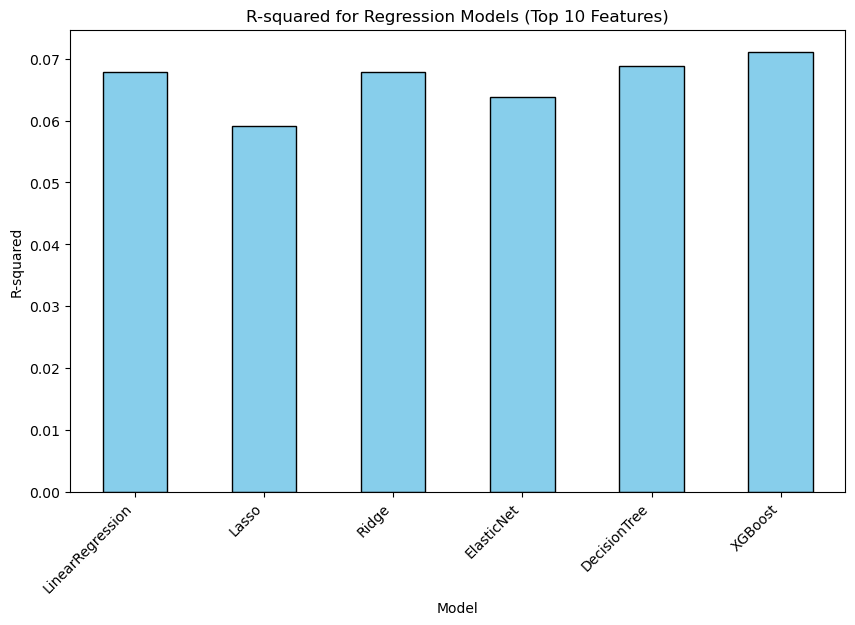

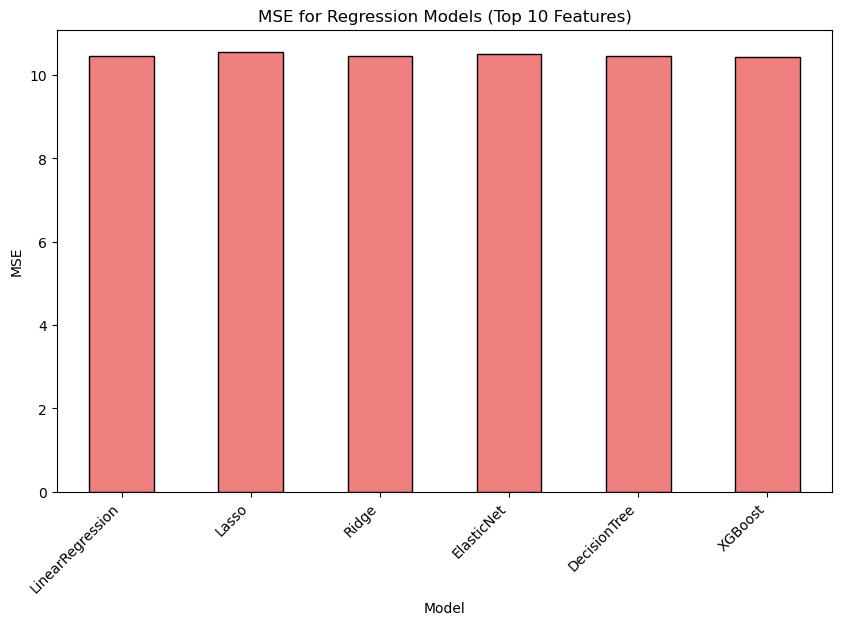

In [42]:
# Train an initial XGBoost model to get feature importances
X = data_model4.drop(columns=['EDUC'])
y = data_model4['EDUC']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
initial_model = XGBRegressor(random_state=42)
initial_model.fit(X_train, y_train)

# Get feature importances
feature_importance = initial_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


# Select top 10 features
top_features = feature_importance_df.head(10)['Feature'].tolist()

# Create new feature set with top 20 features
X_top = data_model4[top_features]

# Normalize the features
X_top_scaled = scaler.fit_transform(X_top)

# Split the data into training and testing sets
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top_scaled, y, test_size=0.2, random_state=42)


# Define the models
models = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(alpha=0.1),
    'Ridge': Ridge(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
}

results_top = {}
for name, model in models.items():
    model.fit(X_train_top, y_train_top)
    y_pred = model.predict(X_test_top)
    r2 = r2_score(y_test_top, y_pred)
    mse = mean_squared_error(y_test_top, y_pred)
    results_top[name] = {'R2': r2, 'MSE': mse}
    print(f'{name} R-squared: {r2:.6f}, MSE: {mse:.6f}')


# Convert the results dictionary to a pandas DataFrame
results_top_df = pd.DataFrame.from_dict(results_top, orient='index', columns=['R2', 'MSE'])

# Create a bar plot of the R-squared values
ax = results_top_df['R2'].plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
ax.set_title('R-squared for Regression Models (Top 10 Features)')
ax.set_xlabel('Model')
ax.set_ylabel('R-squared')
plt.xticks(rotation=45, ha='right')
plt.show()

# Create a bar plot of the MSE values
ax = results_top_df['MSE'].plot(kind='bar', figsize=(10, 6), color='lightcoral', edgecolor='black')
ax.set_title('MSE for Regression Models (Top 10 Features)')
ax.set_xlabel('Model')
ax.set_ylabel('MSE')
plt.xticks(rotation=45, ha='right')
plt.show()

In [43]:
# Example: Hyperparameter tuning for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3]
}

xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='r2')
grid_search.fit(X_train_top, y_train_top)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best R-squared score: ", grid_search.best_score_)

# Use the best estimator to predict
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test_top)
best_r2 = r2_score(y_test_top, y_pred_best)
best_mse = mean_squared_error(y_test_top, y_pred_best)

print(f'Best XGBoost R-squared: {best_r2:.3f}, MSE: {best_mse:.3f}')

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best R-squared score:  0.07266129552638774
Best XGBoost R-squared: 0.074, MSE: 10.396


In [44]:
# Perform cross-validation on the tuned XGBoost model
cv_scores = cross_val_score(best_xgb, X_top_scaled, y, cv=5, scoring='r2')

print("Cross-validated R-squared scores:", cv_scores)
print("Mean R-squared score from cross-validation:", cv_scores.mean())

Cross-validated R-squared scores: [0.09190104 0.05869319 0.04784759 0.05922376 0.08601696]
Mean R-squared score from cross-validation: 0.0687365059821546


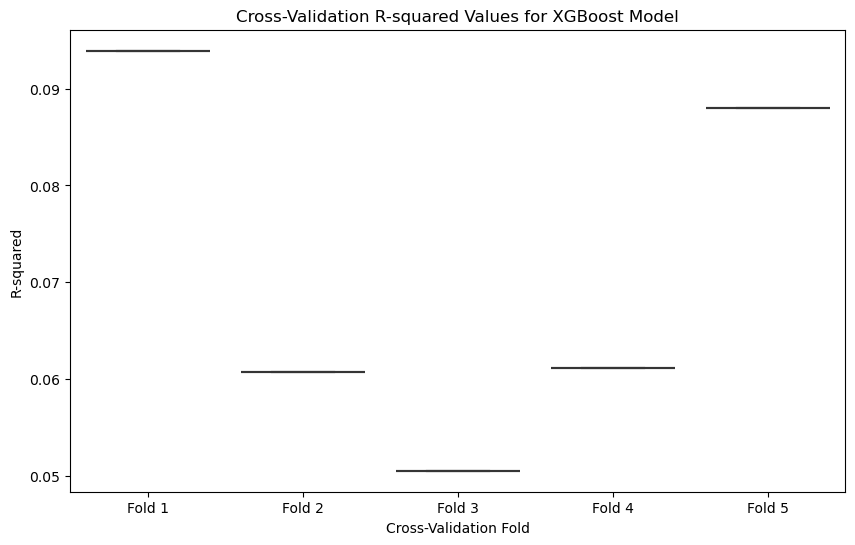

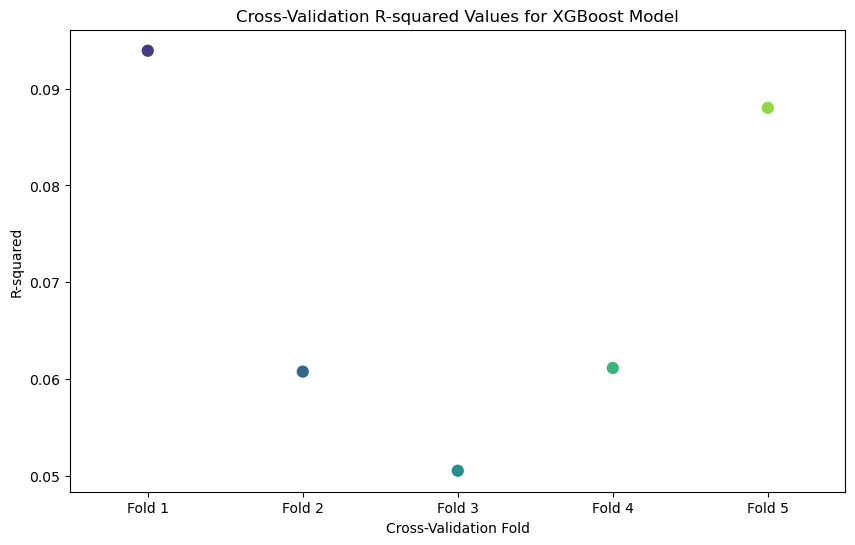

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


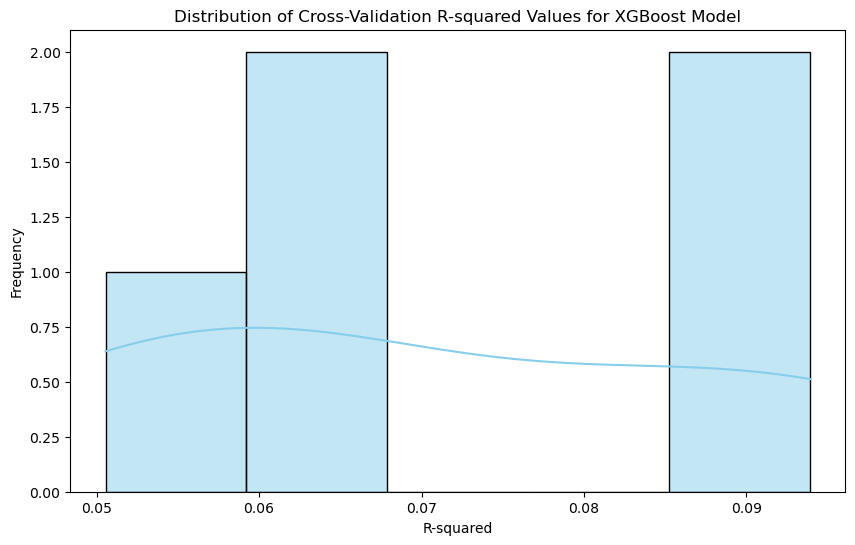

In [45]:
# Cross-validation R-squared scores
cv_scores = [0.09391391, 0.06077983, 0.05054606, 0.06115764, 0.08801798]

# Create a DataFrame for plotting
cv_results_df = pd.DataFrame({
    'Fold': ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'],
    'R-squared': cv_scores
})

# Plotting the cross-validation results
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fold', y='R-squared', data=cv_results_df, palette='viridis')
plt.title('Cross-Validation R-squared Values for XGBoost Model')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('R-squared')
plt.show()

# Plotting the cross-validation results with a point plot
plt.figure(figsize=(10, 6))
sns.pointplot(x='Fold', y='R-squared', data=cv_results_df, palette='viridis', markers='o', linestyles='-')
plt.title('Cross-Validation R-squared Values for XGBoost Model')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('R-squared')
plt.show()

# Plotting the distribution of cross-validation scores
plt.figure(figsize=(10, 6))
sns.histplot(cv_scores, kde=True, bins=5, color='skyblue')
plt.title('Distribution of Cross-Validation R-squared Values for XGBoost Model')
plt.xlabel('R-squared')
plt.ylabel('Frequency')
plt.show()


## Improved Two Stage Regression

#### Two Stage Model (6)

In [56]:
from xgboost import XGBRegressor
# Stage 1: XGBoost Regression where EDUC is the target variable
feature_df1 = data_model3[['RACE', 'ESOCENT', 'SOATL', 'WSOCENT', 'ENOCENT', 'MIDATL', 'SMSA', 'WNOCENT', 'YR21', 'YR20']]

X_stage1 = feature_df1
y_stage1 = data_model3['EDUC']

#Best parameters found:  {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100}
xgb_reg = XGBRegressor(objective='reg:squarederror', max_depth=3, learning_rate=0.3, n_estimators=100)

# Train the model
xgb_reg.fit(X_stage1, y_stage1)

# Make predictions
data['pred_education'] = xgb_reg.predict(X_stage1)

mse_stage_one = mean_squared_error(data['pred_education'], data['EDUC'])
print(f"Mean-Squared Error (Stage 1): {mse_stage_one}")

# Stage 2: OLS Regression where Log Weekly Wage is the outcome variable
stage2_formula = ('LWKLYWGE ~ pred_education + YR20 + YR21 + YR22 + YR23 + YR24 + YR25 + YR26 + YR27 + YR28 + RACE + '
                  'MARRIED + SMSA + NEWENG + MIDATL + ENOCENT + WNOCENT + SOATL + ESOCENT + WSOCENT + MT')
stage2 = smf.ols(stage2_formula, data=data).fit()

# Adding a column to the original data frame of the predicted values of Log Weekly Wage to use in the manual R-Squared Test
data['predicted_LWKLYWGE'] = stage2.predict(data)

mse_stage_two = mean_squared_error(data['predicted_LWKLYWGE'], data['LWKLYWGE'])

# Printing OLS Regression Results with dotted lines for Readability
print('--------------------------------------------------------------------------------')
print('----------------------Regression of Interest Below------------------------------')
print('--------------------------------------------------------------------------------')
print(f"Mean-Squared Error (Stage 2): {mse_stage_two}")
print(stage2.summary())

Mean-Squared Error (Stage 1): 10.473397254943848
--------------------------------------------------------------------------------
----------------------Regression of Interest Below------------------------------
--------------------------------------------------------------------------------
Mean-Squared Error (Stage 2): 0.37614142690264285
                            OLS Regression Results                            
Dep. Variable:               LWKLYWGE   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     1503.
Date:                Fri, 21 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:00:56   Log-Likelihood:            -2.2991e+05
No. Observations:              247199   AIC:                         4.599e+05
Df Residuals:                  247177   BIC:                         4.601e+05
Df Model:                 

#### Two Stage Model (8)

In [55]:
# Stage 1: XGBoost Regression where EDUC is the target variable
feature_df2 = data_model4[['RACE', 'ESOCENT', 'SOATL', 'WSOCENT', 'ENOCENT', 'MIDATL', 'SMSA', 'WNOCENT', 'AGEQ', 'MT']]

X_stage1 = feature_df2
y_stage1 = data_model4['EDUC']

#'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200
xgb_reg = XGBRegressor(objective='reg:squarederror', max_depth=3, learning_rate=0.1, n_estimators=200)

# Train the model
xgb_reg.fit(X_stage1, y_stage1)

# Make predictions
data['pred_education'] = xgb_reg.predict(X_stage1)

mse_stage_one = mean_squared_error(data['pred_education'], data['EDUC'])
print(f"Mean-Squared Error (Stage 1): {mse_stage_one}")

# Stage 2: OLS Regression where Log Weekly Wage is the outcome variable
stage2_formula = ('LWKLYWGE ~ pred_education + YR20 + YR21 + YR22 + YR23 + YR24 + YR25 + YR26 + YR27 + YR28 + RACE + '
                  'MARRIED + SMSA + NEWENG + MIDATL + ENOCENT + WNOCENT + SOATL + ESOCENT + WSOCENT + MT')
stage2 = smf.ols(stage2_formula, data=data).fit()

# Adding a column to the original data frame of the predicted values of Log Weekly Wage to use in the manual R-Squared Test
data['predicted_LWKLYWGE'] = stage2.predict(data)

mse_stage_two = mean_squared_error(data['predicted_LWKLYWGE'], data['LWKLYWGE'])

# Printing OLS Regression Results with dotted lines for Readability
print('--------------------------------------------------------------------------------')
print('----------------------Regression of Interest Below------------------------------')
print('--------------------------------------------------------------------------------')
print(f"Mean-Squared Error (Stage 2): {mse_stage_two}")
print(stage2.summary())

Mean-Squared Error (Stage 1): 10.45262622833252
--------------------------------------------------------------------------------
----------------------Regression of Interest Below------------------------------
--------------------------------------------------------------------------------
Mean-Squared Error (Stage 2): 0.37626562378564776
                            OLS Regression Results                            
Dep. Variable:               LWKLYWGE   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     1498.
Date:                Fri, 21 Jun 2024   Prob (F-statistic):               0.00
Time:                        14:59:02   Log-Likelihood:            -2.2995e+05
No. Observations:              247199   AIC:                         4.599e+05
Df Residuals:                  247177   BIC:                         4.602e+05
Df Model:                  